In [1]:
!pip install torchio monai

     |████████████████████████████████| 156 kB 893 kB/s eta 0:00:01
     |████████████████████████████████| 650 kB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 1.9 MB/s eta 0:00:011     |██████████████████████████▉     | 2.8 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 10.3 MB/s eta 0:00:01
     |████████████████████████████████| 48.4 MB 29 kB/s  eta 0:00:01    |█▉                              | 2.7 MB 1.9 MB/s eta 0:00:25     |█▉                              | 2.8 MB 1.9 MB/s eta 0:00:25     |██▋                             | 4.0 MB 1.9 MB/s eta 0:00:24     |████████▋                       | 13.1 MB 2.0 MB/s eta 0:00:18     |██████████████▋                 | 22.0 MB 2.3 MB/s eta 0:00:12     |█████████████████████████▏      | 38.0 MB 2.6 MB/s eta 0:00:05


In [3]:
!nvidia-smi

Fri Oct  1 18:31:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 470.63.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  Off  | 00000000:07:00.0  On |                    0 |
| N/A   46C    P0    53W / 300W |   1563MiB / 32505MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   

In [1]:
import numpy as np
import os
from tqdm import tqdm
import torch as t
from torch.utils import data
import matplotlib.pyplot as plt
#plt.rcParams.update({'font.size': 20})
from torch import nn
import torch.nn.functional as F
import torch as t
from torch.utils import data
from utils1 import *
from SegLargeOrgan import UnetModel
from SegSmallOrgan import UnetModel as UnetmodelSmall
#from RBBlurmodel import UnetModel
#from RBBlurmodelSmall import UnetModel as UnetmodelSmall
t.backends.cudnn.enabled = True
os.environ["CUDA_VISIBLE_DEVICES"]="2"
device = t.device('cuda:0')
#device = "cuda:0"

Lung_R_path = "/workstation/seenia/autocontouring/HeartEso/LungsnSpinal/ThoraxLungRCropped_CT"
Lung_L_path = "/workstation/seenia/autocontouring/HeartEso/LungsnSpinal/ThoraxLungLCropped_CT"
spine_path = "/workstation/seenia/autocontouring/HeartEso/LungsnSpinal/ThoraxSpinalCropped_CT"
eso_path = "/workstation/seenia/autocontouring/HeartEso/HeartnEso/ThoraxEsoCropped_CT"
heart_path = "/workstation/seenia/autocontouring/HeartEso/HeartnEso/ThoraxHeartCropped_CT"

Lung_L_crop = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/crop_values/lungLfile.txt"
Lung_R_crop = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/crop_values/lungRfile.txt"
spine_crop = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/crop_values/spinalfile.txt"
eso_crop = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/crop_values/esophagusfile.txt"
heart_crop = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/crop_values/heartfile.txt"

Lung_R_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-32_Lung_R_epochs_120_trainsize_36_loss_dice[0.1,1.9]_trainloss_0.7951728105545044"
Lung_L_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-32_Lung_L_epochs_120_trainsize_36_loss_dice[0.1,1.9]_trainloss_0.9063127897679806"
spine_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/smallOrgan/SmallSpinal_80Epochs3.8146427534520626"
#spine_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/smallOrgan/weight/SmallSpinal_80Epochs3.6016824953258038"
#eso_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/smallOrgan/weight/SmallEso_80Epoch5.67391224950552"
eso_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/smallOrgan/SmallEso_80Epoch5.476922616362572"
heart_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-32_Heart_epochs_160_trainsize_36_loss_dice[0.5,1.5]_trainloss_2.180488631129265"

'''
Lung_R_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-32_Lung_R_epochs_120_trainsize_36_loss_dice[0.1,1.9]_trainloss_0.7951728105545044"
Lung_L_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-32_Lung_L_epochs_120_trainsize_36_loss_dice[0.1,1.9]_trainloss_0.9063127897679806"
#spine_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-64_Spine_epochs_80_trainsize_36_loss_dice[0.01,1.99]_trainloss_3.1009323112666607"
spine_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/smallOrgan/weight/SmallSpinal_80Epochs3.6016824953258038"

#eso_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-64_Eso_epochs_80_trainsize_36_loss_dice[0.01,1.99]_trainloss_4.749331243336201"
eso_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/smallOrgan/weight/SmallEso_80Epoch5.67391224950552"
heart_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/FinalWeights/@@RBLURUnet_3D_3level-32_Heart_epochs_160_trainsize_36_loss_dice[0.5,1.5]_trainloss_2.180488631129265"
#tried small heart
#heart_weight = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/3D-Model/smallOrgan/weight/SmallHeart_100Epoch1.3857840709388256"
'''

mask_names = ['Lung_L','Lung_R','Heart','SpinalCord','Esophagus']

masks = {
    'Lung_L':{'path':Lung_L_path,'weight':Lung_L_weight,'crop':Lung_L_crop},
     'Lung_R':{'path':Lung_R_path,'weight':Lung_R_weight,'crop':Lung_R_crop},
     'Heart':{'path':heart_path,'weight':heart_weight,'crop':heart_crop},
     'SpinalCord':{'path':spine_path,'weight':spine_weight,'crop':spine_crop},
     'Esophagus':{'path':eso_path,'weight':eso_weight,'crop':eso_crop}
        }

actual_data_path = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/data/real_withoutCROP_processed/"

#weight_path="/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/weights/RBLURUnet_3D_spineandeso_epochs_30_trainsize_45_loss_dice_trainloss_7.14291475713253"
#save_path = "/workstation/seenia/autocontouring/Thoracic_Autocontouring/predicted/"

In [2]:
def get_crops(path):
    file1 = open(path, 'r')
    lines = file1.readlines()
    croplims={}
    for i in lines:
        name = i.strip().split(' ')[0].split(',')[0][3:]
        zmax = int(i.strip().split(' ')[0].split('(')[1][:-1])
        lims = [int(x) for x in i.strip().split(' ')[-3].split('(')[0][:-1].split(',')]
        lims = [lims[0],zmax - lims[1],lims[2],512-lims[3],lims[4],512-lims[5]]
        croplims[name] = lims
    return croplims

def pad_mask(predmask,croplims):
    predmask = F.pad(predmask, [croplims[4], croplims[5], croplims[2], croplims[3] , croplims[0], croplims[1]])
    return predmask

In [3]:
def DiceCoeff(y_true,y_pred):
    
    maxvar=y_pred   
    y_true = y_true.permute(0,2,3,4,1)
    maxvar = maxvar.permute(0,2,3,4,1)

    y_true_shape = y_true.shape
    y_true = t.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
    maxvar = t.reshape(maxvar, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
    
    multed = t.sum(y_true * maxvar, dim=1)
    summed = t.sum(y_true + maxvar, dim=1)
    
    dices =2. * (multed+1)/(summed+1)
    
    return dices    

def precision(y_true,y_pred):

    y_true = y_true.permute(0,2,3,4,1)
    y_pred = y_pred.permute(0,2,3,4,1)

    y_true_shape = y_true.shape
    y_true = t.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
    y_pred = t.reshape(y_pred, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
   
    TP = t.sum(y_true * y_pred, dim=1)
    FP = t.sum((1-y_true) * y_pred, dim=1)
    FN = t.sum(y_true * (1-y_pred), dim=1)
    
    precision = ((TP) / (TP + FP))
    return precision  

def recall(y_true,y_pred):
    
    y_true = y_true.permute(0,2,3,4,1)
    y_pred = y_pred.permute(0,2,3,4,1)

    y_true_shape = y_true.shape
    y_true = t.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
    y_pred = t.reshape(y_pred, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
   
    TP = t.sum(y_true * y_pred, dim=1)
    FP = t.sum((1-y_true) * y_pred, dim=1)
    FN = t.sum(y_true * (1-y_pred), dim=1)
    
    recall = ((TP) / (TP + FN))

    return recall  

def iou(y_true,y_pred):
    
    y_true = y_true.permute(0,2,3,4,1)
    y_pred = y_pred.permute(0,2,3,4,1)

    y_true_shape = y_true.shape
    y_true = t.reshape(y_true, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
    y_pred = t.reshape(y_pred, [-1, y_true_shape[1]*y_true_shape[2]*y_true_shape[3], y_true_shape[4]])
    
    intersection = t.sum(y_true * y_pred, dim=1)
    total = t.sum(y_true + y_pred, dim=1)
    union = total - intersection 
        
    IoU = (intersection)/(union)

    return IoU

In [5]:
def post_process_combined(pred,logits):
    maxvar = t.zeros_like(pred)
    for i in range(logits.shape[1]):
        maxvar[:,i,...] = t.argmax(logits,1)==i
    logits = maxvar
    pos = (t.sum(pred,axis=1)>1).reshape((pred.shape[0],1,pred.shape[2],pred.shape[3],pred.shape[4]))
    pos = t.repeat_interleave(pos,repeats = pred.shape[1],dim=1)

    pred = t.where(pos, logits, pred)
    return pred


 58%|█████▊    | 7/12 [00:00<00:00, 67.05it/s]

Predicting : Lung_L


100%|██████████| 12/12 [00:16<00:00,  1.47s/it]


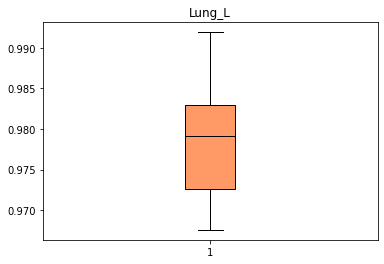

100%|██████████| 12/12 [00:00<00:00, 79.11it/s]

Performance of Lung_L:
Mean Dice : 0.9787535  +/-  [0.00695995]
Mean 95 percentile HD : 1.4682000270784625  +/-  [0.51093576]
Mean MSD : 0.4683512647106869  +/-  [0.19397518]
Mean Precision : 0.983483  +/-  [0.00974582]
Mean Recall : 0.9743218  +/-  [0.01576264]
Mean IoU : 0.95848006  +/-  [0.01336771]

Predicting : Lung_R



100%|██████████| 12/12 [00:18<00:00,  1.58s/it]


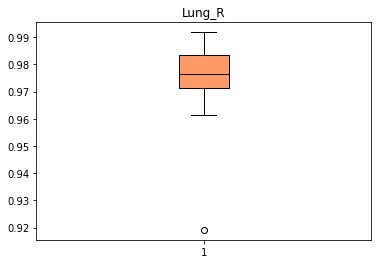

100%|██████████| 12/12 [00:00<00:00, 203.41it/s]


Performance of Lung_R:
Mean Dice : 0.9734321  +/-  [0.01850931]
Mean 95 percentile HD : 2.700310777323382  +/-  [2.18898493]
Mean MSD : 0.5501159584479137  +/-  [0.28159192]
Mean Precision : 0.97143745  +/-  [0.03397675]
Mean Recall : 0.9763667  +/-  [0.01863985]
Mean IoU : 0.94885045  +/-  [0.03399278]

Predicting : Heart


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


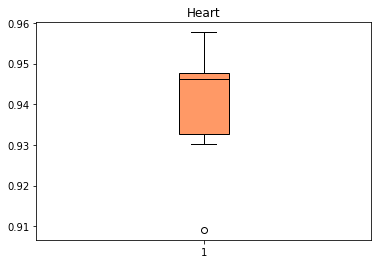

100%|██████████| 12/12 [00:00<00:00, 312.17it/s]


Performance of Heart:
Mean Dice : 0.94055176  +/-  [0.01304377]
Mean 95 percentile HD : 3.632402398062864  +/-  [0.94286062]
Mean MSD : 1.088486288090781  +/-  [0.23698073]
Mean Precision : 0.93593854  +/-  [0.02606629]
Mean Recall : 0.9460583  +/-  [0.02111048]
Mean IoU : 0.88805443  +/-  [0.02300353]

Predicting : SpinalCord


100%|██████████| 12/12 [00:03<00:00,  2.42it/s]


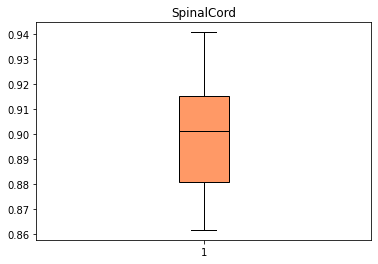

100%|██████████| 12/12 [00:00<00:00, 442.91it/s]


Performance of SpinalCord:
Mean Dice : 0.89895105  +/-  [0.02179754]
Mean 95 percentile HD : 1.8446302428426213  +/-  [0.425056]
Mean MSD : 0.6660720992275315  +/-  [0.11634341]
Mean Precision : 0.89471716  +/-  [0.05932702]
Mean Recall : 0.9076449  +/-  [0.03550602]
Mean IoU : 0.81711596  +/-  [0.03601339]

Predicting : Esophagus


100%|██████████| 12/12 [00:14<00:00,  1.30s/it]


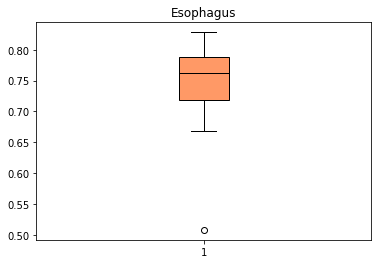

Performance of Esophagus:
Mean Dice : 0.738044  +/-  [0.08132723]
Mean 95 percentile HD : 6.646690312854061  +/-  [7.47409857]
Mean MSD : 1.920005351159425  +/-  [2.25725582]
Mean Precision : 0.80598754  +/-  [0.08354004]
Mean Recall : 0.6956008  +/-  [0.11543729]
Mean IoU : 0.5907598  +/-  [0.09303103]



In [4]:
from monai.metrics import HausdorffDistanceMetric,SurfaceDistanceMetric

final_pred = {}
actual_masks={}
logits = {}

hd = HausdorffDistanceMetric(percentile=95,reduction="none",include_background=True)
msd = SurfaceDistanceMetric(include_background=True)

for organ in mask_names:
    print("Predicting : " + organ)
    
    testdataset = CT_Dataset(masks[organ]['path'], istest=True,istransform=False,organ=organ)
    testdataloader = data.DataLoader(testdataset,num_workers=0,batch_size=1, shuffle=False)
    croplimits = get_crops(masks[organ]['crop']) #Getting crop limits for the current organ
    
    if organ in ['SpinalCord','Esophagus']:
        model = UnetmodelSmall(in_channels=1,out_classes=2)
    else:
        model = UnetModel(in_channels=1,out_classes=2)
        
    model.load_state_dict(t.load(masks[organ]['weight'],map_location=device)) #Loading model weights for current organ
    model.eval()
    
    dices=[]
    hds=[]
    precisions=[]
    recalls=[]
    ious=[]
    msds=[]
    
    for image,mask,name in  tqdm(testdataloader):
        name=name[0]
        if name not in final_pred:
            final_pred[name]=[]
            actual_masks[name]=[]
            logits[name]=[] 
            
        pred = t.zeros_like(mask)
        mask = mask.to(device)
        with t.no_grad():
            pred_mask = model(image.to(device))
            pred_mask = F.softmax(pred_mask,dim=1)
            pred = post_process(pred_mask)            
            
            dices.append(DiceCoeff(mask[:,1:,...],pred[:,1:,...]).cpu().numpy())
            precisions.append(precision(mask[:,1:,...],pred[:,1:,...]).cpu().numpy())
            recalls.append(recall(mask[:,1:,...],pred[:,1:,...]).cpu().numpy())
            ious.append(iou(mask[:,1:,...],pred[:,1:,...]).cpu().numpy())
            hds.append(hd(mask[:,1:,...].permute(0,1,3,4,2),pred[:,1:,...].permute(0,1,3,4,2))[0])
            msds.append(msd(mask[:,1:,...].permute(0,1,3,4,2),pred[:,1:,...].permute(0,1,3,4,2))[0])

            act_mask = np.load(actual_data_path+name+"/structure/"+organ+".npy").astype(np.uint8)
            final_pred[name].append(pad_mask(pred[:,1:,...],croplimits[name]))
            logits[name].append(pad_mask(pred_mask[:,1:,...],croplimits[name]))
            actual_masks[name].append(act_mask.reshape((1,1,)+act_mask.shape))
            
            ###Check if it needs to be numpy or cpu
            
            if organ== mask_names[-1]:
                final_pred[name] = t.cat(final_pred[name],axis=1).cpu().numpy()
                actual_masks[name] = np.concatenate(actual_masks[name],axis=1)
                logits[name] = t.cat(logits[name],axis=1).cpu().numpy()
        
        del image,pred_mask, pred, act_mask
        
    plt.figure()
    plt.title(organ)
    plt.boxplot(np.asarray(dices).reshape((12,1)),boxprops=dict(facecolor="#ff9966"),patch_artist=True,medianprops=dict(color="#000000"))
    plt.show()
    #plt.savefig("/workstation/seenia/autocontouring/Thoracic_Autocontouring/manu/boxplots/"+organ+".png",dpi=200)
    
    mean_dice = np.mean(np.asarray(dices).reshape((12,1)),axis=0)
    mean_hd = np.mean(np.asarray(hds).reshape((12,1)),axis=0)
    mean_msd = np.mean(np.asarray(msds).reshape((12,1)),axis=0)
    mean_precision = np.mean(np.asarray(precisions).reshape((12,1)),axis=0)
    mean_recall = np.mean(np.asarray(recalls).reshape((12,1)),axis=0)
    mean_iou = np.mean(np.asarray(ious).reshape((12,1)),axis=0)
    
    print("Performance of "+organ+":")
    print("Mean Dice : "+ str(mean_dice[0]), " +/- ", np.std(np.asarray(dices).reshape((12,1)),axis=0))
    print("Mean 95 percentile HD : "+ str(mean_hd[0]), " +/- ",np.std(np.asarray(hds).reshape((12,1)),axis=0))
    print("Mean MSD : "+ str(mean_msd[0]), " +/- ",np.std(np.asarray(msds).reshape((12,1)),axis=0))
    print("Mean Precision : "+ str(mean_precision[0]), " +/- ", np.std(np.asarray(precisions).reshape((12,1)),axis=0))
    print("Mean Recall : "+ str(mean_recall[0]), " +/- ",  np.std(np.asarray(recalls).reshape((12,1)),axis=0))
    print("Mean IoU : "+ str(mean_iou[0]), " +/- ",np.std(np.asarray(ious).reshape((12,1)),axis=0))
    print("")
    
    del model
    

In [11]:
print("std : ", np.std(np.asarray(dices).reshape((12,1)),axis=0))
print("var : ", np.var(np.asarray(dices).reshape((12,1)),axis=0))

std :  [0.09737714]
var :  [0.00948231]


In [6]:

x=[]
dices=[]
hds=[]
precisions=[]
recalls=[]
ious=[]
msds=[]

for name in final_pred.keys(): 
    #print(DiceCoeff(t.from_numpy(final_pred[name]),t.from_numpy(actual_masks[name])))
    print(np.count_nonzero(np.sum(final_pred[name],axis=1)>1))
    final_pred[name] = post_process_combined(t.from_numpy(final_pred[name]).to('cuda:0'),logits[name])
    print(np.count_nonzero(np.sum(final_pred[name],axis=1)>1))
    
    dices.append(DiceCoeff(t.from_numpy(final_pred[name]),t.from_numpy(actual_masks[name])).cpu().numpy())
    precisions.append(precision(t.from_numpy(final_pred[name]),t.from_numpy(actual_masks[name])).cpu().numpy())
    recalls.append(recall(t.from_numpy(final_pred[name]),t.from_numpy(actual_masks[name])).cpu().numpy())
    ious.append(iou(t.from_numpy(final_pred[name]),t.from_numpy(actual_masks[name])).cpu().numpy())
    hds.append(hd(t.from_numpy(final_pred[name]).permute(0,1,3,4,2),t.from_numpy(actual_masks[name]).permute(0,1,3,4,2))[0])
    msds.append(msd(t.from_numpy(final_pred[name]).permute(0,1,3,4,2),t.from_numpy(actual_masks[name]).permute(0,1,3,4,2))[0])

    '''
    #print(name,final_pred[name].shape,actual_masks[name].shape)
    pred = final_pred[name]
    mask = logits[name]
    plt.figure(figsize=(15, 15))
    plt.subplot(2, 1,1)
    plt.imshow(pred[0,0,slide,...])
    plt.subplot(2, 1,2)
    plt.imshow(mask[0,0,slide,...])
    plt.axis('off')
    break
    '''
    x.append(DiceCoeff(t.from_numpy(final_pred[name]),t.from_numpy(actual_masks[name])).numpy())
del logits,actual_masks

494


TypeError: argmax(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
mean_dice = np.mean(np.asarray(dices).reshape((12,1)),axis=0)
mean_hd = np.mean(np.asarray(hds).reshape((12,1)),axis=0)
mean_msd = np.mean(np.asarray(msds).reshape((12,1)),axis=0)
mean_precision = np.mean(np.asarray(precisions).reshape((12,1)),axis=0)
mean_recall = np.mean(np.asarray(recalls).reshape((12,1)),axis=0)
mean_iou = np.mean(np.asarray(ious).reshape((12,1)),axis=0)
print("Evaluation Metrics:")
print("Mean Dice : "+ str(mean_dice[0]))
print("Mean 95 percentile HD : "+ str(mean_hd[0]))
print("Mean MSD : "+ str(mean_msd[0]))
print("Mean Precision : "+ str(mean_precision[0]))
print("Mean Recall : "+ str(mean_recall[0]))
print("Mean IoU : "+ str(mean_iou[0]))
print("")

In [17]:
maxvar = t.zeros_like(pred)
for i in range(3):
    maxvar[:,i,...] = t.argmax(pred,1)==i

IndexError: index 3 is out of bounds for dimension 1 with size 3

In [22]:
image[...].shape, mask.shape

(torch.Size([1, 1, 153, 236, 272]), torch.Size([1, 6, 153, 236, 272]))

In [23]:
maxvar = maxvar.cpu().numpy().reshape(pred.shape[1],pred.shape[2],pred.shape[3],pred.shape[4]).transpose(1,0,2,3)
image = image[...].numpy().reshape(image.shape[2],image.shape[3],image.shape[4])
mask = mask.numpy().reshape(mask.shape[1],mask.shape[2],mask.shape[3],mask.shape[4]).transpose(1,0,2,3)

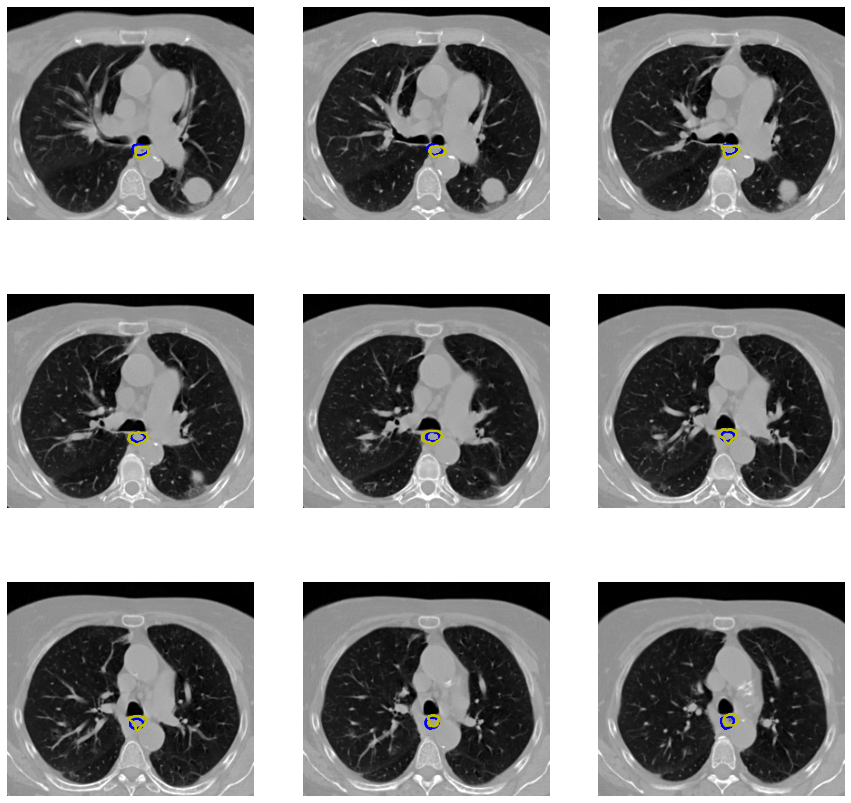

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
slide = 40
plt.figure(figsize=(15, 15))
for i in range(80,89):
    plt.subplot(3, 3, i-80 + 1)
    plt.imshow(image[i,...], cmap="gray")
    plt.contour(maxvar[i,5,...],colors='b')
    #plt.contour(maxvar[i,2,...],colors='g')
    #plt.contour(maxvar[i,3,...],colors='r')
    plt.contour(mask[i,5,...],colors='y')
    #plt.contour(maxvar[i,4,...],colors='y')
    #plt.contour(maxvar[i,5,...],colors='w')
    #plt.contour(mask[i,1,...],colors='r')
    plt.axis('off')